- 贝尔曼方程的逐步推导与直观含义
- 标量形式与矩阵形式
- 解析解 `(I - γP)^{-1} R`（当可逆时）
- 迭代解（贝尔曼备份 / 动态规划）与其收敛行为
- 与 Monte Carlo 估计比较
- 两个直观例子：走廊机器人与库存（inventory）简单模型

In [71]:
# 基础库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 便于显示大矩阵（notebook 环境下）
np.set_printoptions(precision=4, suppress=True)


## 1) 定义一个小的 MRP（马尔可夫奖励过程）用于示范
我们用之前的“7 房间走廊”示例（s1..s7）：
- 奖励向量 R = [5,0,0,0,0,0,10]
- 简单随机游走转移 P（内部向左/向右 0.5，边界反射）
- 折扣因子 γ（可调整）

In [72]:
# --------- MRP 定义 ----------
N = 7  # 状态数 s1..s7
R = np.array([1, 4, 8, 10, 8, 4, 1], dtype=float)  # 即时奖励（进入某状态获得的奖励）
gamma = 0.5  # 折扣因子（可改为其他值试验）

# 构建转移矩阵 P（随机游走 + 边界反射）
P = np.zeros((N, N))
for i in range(N):
    if i == 0:
        P[i, 0] = 0.5  # s1 保留 50%
        P[i, 1] = 0.5  # s1 -> s2
    elif i == N - 1:
        P[i, N-1] = 0.5
        P[i, N-2] = 0.5
    else:
        P[i, i-1] = 0.5
        P[i, i+1] = 0.5

# 打印检查
print("奖励 R: ", R)
print("G: ", gamma)
print("转移矩阵 P (rows = current state, cols = next state):\n", P)


奖励 R:  [ 1.  4.  8. 10.  8.  4.  1.]
G:  0.5
转移矩阵 P (rows = current state, cols = next state):
 [[0.5 0.5 0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.5 0.5]]


### 标量贝尔曼方程回顾（单个状态）
贝尔曼方程（标量形式）：
V(s) = R(s) + γ * Σ_{s'} p(s' | s) V(s')

直观含义：
- 当前状态的价值 = 立即能拿到的奖励 + 折扣后的“未来状态的期望价值”

In [73]:
# 逐状态打印贝尔曼方程中的右边各项，便于理解
V_dummy = np.zeros(N)  # 随机的初始 V，用于演示 pV 项如何计算
rhs = R + gamma * (P @ V_dummy)  # R + γ Σ p(s'|s) V(s')
print("示例：当 V = 0 时，贝尔曼右侧等于即时奖励：")
for i in range(N):
    print(f"V({i+1}) = R({i+1}) + γ Σ p(s'|s{i+1}) V(s') = {rhs[i]:.4f}")


示例：当 V = 0 时，贝尔曼右侧等于即时奖励：
V(1) = R(1) + γ Σ p(s'|s1) V(s') = 1.0000
V(2) = R(2) + γ Σ p(s'|s2) V(s') = 4.0000
V(3) = R(3) + γ Σ p(s'|s3) V(s') = 8.0000
V(4) = R(4) + γ Σ p(s'|s4) V(s') = 10.0000
V(5) = R(5) + γ Σ p(s'|s5) V(s') = 8.0000
V(6) = R(6) + γ Σ p(s'|s6) V(s') = 4.0000
V(7) = R(7) + γ Σ p(s'|s7) V(s') = 1.0000


## 2) 解析解（矩阵形式）： V = (I - γ P)^{-1} R
当 (I - γ P) 可逆时，我们可以一次性解出所有状态的价值：
V = (I - γ P)^{-1} R

这个方法非常直接，但对大状态空间计算量是 O(N^3)（矩阵求逆或线性求解）。

In [74]:
# 解析解（如果矩阵可逆）
I = np.eye(N)
try:
    V_analytic = np.linalg.solve(I - gamma * P, R)  # 比直接 inv() 更稳定
    print("解析解 V (analytic):\n", V_analytic)
except np.linalg.LinAlgError:
    V_analytic = None
    print("解析解无法计算：矩阵 (I - γP) 奇异或不可逆。")


解析解 V (analytic):
 [ 4.2254  8.6761 14.4789 17.2394 14.4789  8.6761  4.2254]


## 可视化：显示状态价值（解析解）
下面画一个条形图展示 V(s)（如果解析解可用）。

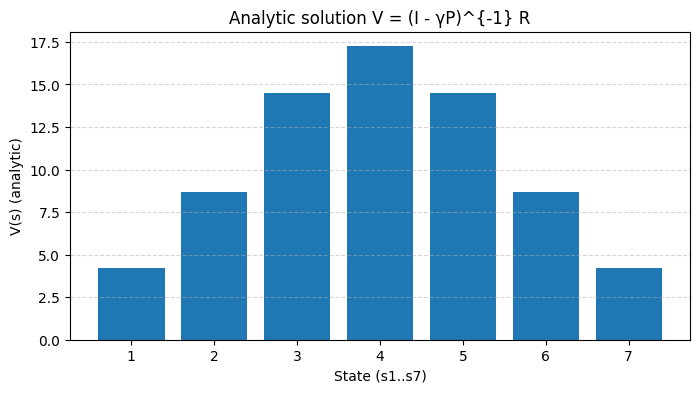

In [75]:
if V_analytic is not None:
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(1, N+1), V_analytic)
    plt.xlabel("State (s1..s7)")
    plt.ylabel("V(s) (analytic)")
    plt.title("Analytic solution V = (I - γP)^{-1} R")
    plt.xticks(np.arange(1, N+1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("解析解不可用，跳过可视化。")


## 3) 迭代贝尔曼备份（动态规划 / 直接迭代求解）
贝尔曼方程给出了一种自洽关系：V = R + γ P V。我们可以把它写成更新公式（一次贝尔曼备份）：
V_{k+1} = R + γ P V_k

反复迭代这一更新（从任意初始 V_0）会收敛到唯一的解（只要 γ < 1 且 P 是良性）。
我们在代码中演示收敛过程并可视化迭代轨迹。

In [76]:
def bellman_iteration(P, R, gamma, V0=None, max_iters=200, tol=1e-8, verbose=False):
    """使用简单的贝尔曼迭代 V_{k+1} = R + γ P V_k 来求解 V"""
    n = len(R)
    V = np.zeros(n) if V0 is None else V0.copy()
    history = [V.copy()]
    for k in range(max_iters):
        V_next = R + gamma * (P @ V)
        history.append(V_next.copy())
        if np.max(np.abs(V_next - V)) < tol:
            if verbose:
                print(f"收敛于第 {k+1} 步，max_delta = {np.max(np.abs(V_next-V)):.2e}")
            return V_next, np.array(history)
        V = V_next
    if verbose:
        print("达到最大迭代次数，未严格满足 tol。")
    return V, np.array(history)

V_iter, history = bellman_iteration(P, R, gamma, max_iters=2000, tol=1e-10, verbose=True)
print("迭代最终得到的 V:\n", V_iter)


收敛于第 37 步，max_delta = 7.49e-11
迭代最终得到的 V:
 [ 4.2254  8.6761 14.4789 17.2394 14.4789  8.6761  4.2254]


## 迭代收敛可视化
接下来画出每个状态随迭代次数变化的曲线（收敛轨迹），以及迭代解与解析解的差别。

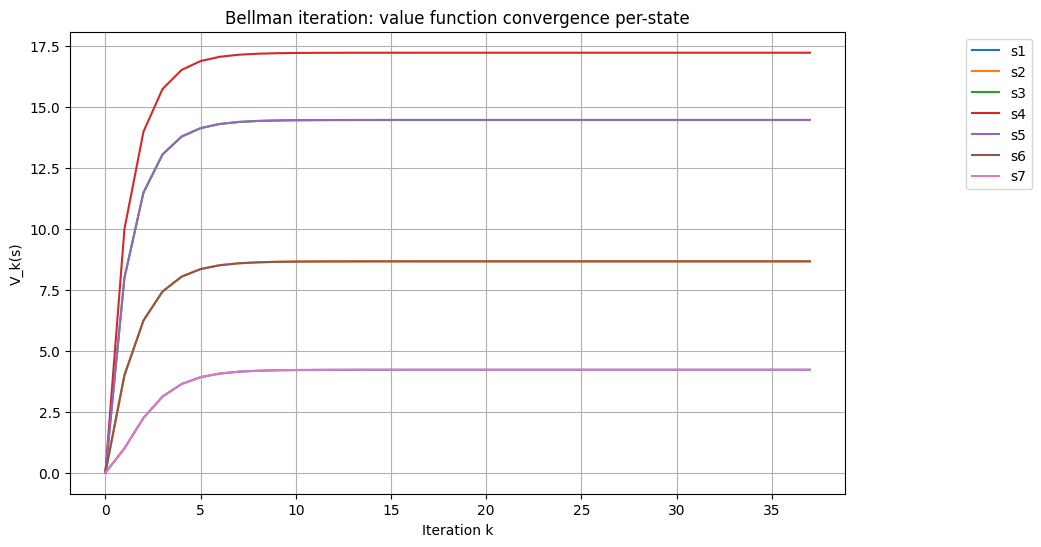

,state,V_iter,V_analytic,abs_diff
0,s1,4.225352,4.225352,7.483969e-11
1,s2,8.676056,8.676056,7.483614e-11
2,s3,14.478873,14.478873,7.484147e-11
3,s4,17.239437,17.239437,7.483081e-11
4,s5,14.478873,14.478873,7.484147e-11
5,s6,8.676056,8.676056,7.483614e-11
6,s7,4.225352,4.225352,7.483969e-11


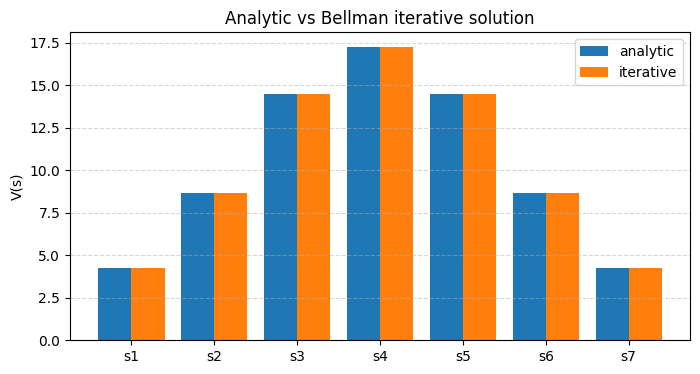

In [77]:
# 画每个状态 V_k 的收敛轨迹（只取前若干次以便查看）
iters_to_plot = min(history.shape[0], 200)
plt.figure(figsize=(10, 6))
for s in range(N):
    plt.plot(history[:iters_to_plot, s], label=f"s{s+1}")
plt.xlabel("Iteration k")
plt.ylabel("V_k(s)")
plt.title("Bellman iteration: value function convergence per-state")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.show()

# 画迭代解 vs 解析解（如果解析解存在）
if V_analytic is not None:
    diff = np.abs(V_iter - V_analytic)
    df = pd.DataFrame({
        "state": [f"s{i+1}" for i in range(N)],
        "V_iter": V_iter,
        "V_analytic": V_analytic,
        "abs_diff": diff
    })
    display(df)
    plt.figure(figsize=(8,4))
    x = np.arange(1, N+1)
    plt.bar(x-0.2, V_analytic, width=0.4, label="analytic")
    plt.bar(x+0.2, V_iter, width=0.4, label="iterative")
    plt.xticks(x, [f"s{i}" for i in range(1, N+1)])
    plt.ylabel("V(s)")
    plt.title("Analytic vs Bellman iterative solution")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("无解析解供对比。")


## 4) Monte Carlo 对比（简单演示）
Monte Carlo 是直接用采样的方式估计状态的期望回报 E[G | s]：
- 从某个状态 s 出发，采样很多条 episode（按指定策略 / 自然转移）
- 每条 episode 计算折扣回报 G
- 对 G 求平均得到 V(s) 的估计

下面我们把 Monte Carlo 的估计和上面的结果做对比（例如对 s4）。

In [78]:
import random

HORIZON = 4  # 为对比用小 horizon（如你教科书示例）
def sample_episode_from(s0, horizon=HORIZON):
    """按 P 的概率从 s0 出发采样一个 finite-horizon episode，
       返回进入各后续状态的奖励序列（长度 = horizon）
    """
    s = s0
    rewards = []
    for _ in range(horizon):
        # 根据 P[s] 的分布采下一个状态
        s = np.random.choice(np.arange(N), p=P[s])
        rewards.append(R[s])  # 进入下一个状态获得的奖励
    return rewards

def mc_estimate_state(s0, n_episodes=5000, horizon=HORIZON):
    returns = []
    for _ in range(n_episodes):
        r = sample_episode_from(s0, horizon)
        G = sum((gamma**k) * r[k] for k in range(len(r)))
        returns.append(G)
    return np.mean(returns), np.std(returns), returns

# 对 s4 (index=3) 做 MC 估计
mc_mean, mc_std, mc_samples = mc_estimate_state(3, n_episodes=5000)
print(f"MC estimate V(s4) ~ {mc_mean:.4f} ± {mc_std:.4f} (std)")
print("迭代法 V(s4) =", V_iter[3], "解析解 V(s4) =", (V_analytic[3] if V_analytic is not None else None))


MC estimate V(s4) ~ 13.7271 ± 2.2646 (std)
迭代法 V(s4) = 17.239436619643477 解析解 V(s4) = 17.239436619718308


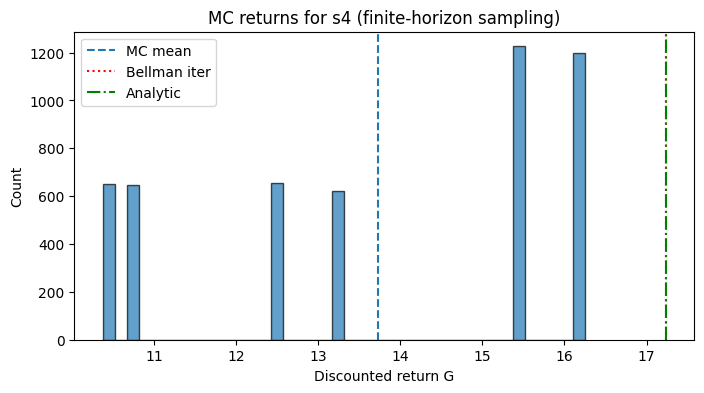

In [79]:
# 画 MC 回报的直方图，并与解析/迭代值画线比较
plt.figure(figsize=(8,4))
plt.hist(mc_samples, bins=40, density=False, alpha=0.7, edgecolor='black')
plt.axvline(mc_mean, linestyle='--', label='MC mean')
plt.axvline(V_iter[3], color='r', linestyle=':', label='Bellman iter')
if V_analytic is not None:
    plt.axvline(V_analytic[3], color='g', linestyle='-.', label='Analytic')
plt.title("MC returns for s4 (finite-horizon sampling)")
plt.xlabel("Discounted return G")
plt.ylabel("Count")
plt.legend()
plt.show()


## 5) 实际应用举例（直观理解）

### 例子 A：走廊机器人（我们一直在用）
- 机器人在 7 个房间随机行走（左右移动）
- s1 有小补给（5），s7 有大补给（10）
- V(s) 表示“站在房间 s 现在的价值”，也就是你现在站在该房间，未来能期望拿到的折扣收益
- 贝尔曼方程告诉我们每个房间的价值可以用它邻居房间的价值去更新（递归关系）

### 例子 B：超市库存（简化）
- 状态 = 存货水平（0..N）
- 每期（一步）可能发生需求（把库存变少）或补货（把库存变多）
- 立即奖励 R(s) 可以代表“每周期的利润”或“缺货惩罚”
- 我们用贝尔曼方程评估不同库存水平的长期预期收益，从而决定最优补货策略（这是策略评估 / 策略迭代的第一步）

上面两类问题在工程上都非常常见：机器人规划、库存管理、排队系统、客服系统等都可以用 MDP/贝尔曼方程建模并求解。

## 6) 关于矩阵解析解的局限与替代方法
- 解析解需要对 (I - γP) 求逆，复杂度 O(N^3)，当状态数 N 很大时不可行。
- 替代方法：
  - 迭代贝尔曼（基于矩阵乘法，每步 O(N^2) 或利用稀疏矩阵加速）
  - TD(0)、TD(λ)、异步更新、样本基方法（样本效率更高并能处理大状态空间）
  - 基于函数逼近（近似值函数、神经网络）用于超大 / 连续状态空间


# 小结与练习建议

1. 手工计算一个非常小的 MRP（例如 N=3）：
   - 写出 P、R、γ
   - 用手算贝尔曼方程解（代数解）
   - 用迭代法验证收敛

2. 改变 γ（例如 0.9、0.99、0.1）观察解析解与迭代收敛速度的变化。

3. 把 P 改为非对称转移（例如从 s2 更容易去 s7），观察 V(s) 的变化。

4. 把 horizon 设为“直到终止状态”并把 s1 与 s7 设为吸收（absorbing）状态，观察 Monte Carlo 与解析解是否一致。

In [80]:
import numpy as np

# -------------------------- 1. 手工计算MRP（N=3）--------------------------
# 定义MRP参数
P = np.array([
    [0.5, 0.3, 0.2],
    [0.1, 0.6, 0.3],
    [0.0, 0.0, 1.0]
])
R = np.array([6, 1, 4])
gamma = 0.5

# 解析解：解线性方程组 V = R + γ*P@V → (I - γ*P)V = R
I = np.eye(len(P))
V_analytic = np.linalg.solve(I - gamma * P, R)
print("解析解 V:", V_analytic.round(2))

解析解 V: [9.84 3.85 8.  ]


In [81]:
# 迭代法验证
def iterative_evaluation(P, R, gamma, tol=1e-6):
    V = np.zeros(len(P))
    while True:
        V_new = R + gamma * P @ V
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    return V

V_iter = iterative_evaluation(P, R, gamma)
print("迭代解 V:", V_iter.round(2))

迭代解 V: [9.84 3.85 8.  ]


In [82]:
# -------------------------- 2. 改变γ的影响 --------------------------
for gamma in [0.1, 0.9, 0.99]:
    V = np.linalg.solve(I - gamma * P, R)
    print(f"γ={gamma} 时解析解:", V.round(2))

γ=0.1 时解析解: [6.45 1.27 4.44]
γ=0.9 时解析解: [40.48 33.57 40.  ]
γ=0.99 时解析解: [399.55 392.5  400.  ]


In [83]:
# -------------------------- 3. 非对称转移矩阵 --------------------------
P_asym = np.array([
    [0.5, 0.3, 0.2],
    [0.0, 0.1, 0.9],  # s2→s3概率提高到0.9
    [0.0, 0.0, 1.0]
])
V_asym = np.linalg.solve(I - gamma * P_asym, R)
print("非对称转移下解析解:", V_asym.round(2))

非对称转移下解析解: [402.   396.67 400.  ]


In [84]:
# -------------------------- 4. 带吸收态的MRP（Monte Carlo vs 解析解）--------------------------
# 定义带吸收态的MRP（s1=0，s7=6为吸收态）
P_absorb = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # s1（吸收）
    [0.1, 0.2, 0.3, 0.4, 0.0, 0.0, 0.0],  # s2
    [0.0, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0],  # s3
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.4],  # s4
    [0.0, 0.0, 0.0, 0.2, 0.5, 0.3, 0.0],  # s5
    [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.7],  # s6
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]   # s7（吸收）
])
R_absorb = np.array([100, -1, -1, -1, -1, -1, 0])
gamma_absorb = 0.5

# 解析解
I_absorb = np.eye(len(P_absorb))
V_analytic_absorb = np.linalg.solve(I_absorb - gamma_absorb * P_absorb, R_absorb)
print("吸收态MRP解析解:", V_analytic_absorb.round(2))

# Monte Carlo估计
def monte_carlo_mrp(P, R, gamma, num_episodes=10000):
    V = np.zeros(len(P))
    returns = {s: [] for s in range(len(P))}
    
    for _ in range(num_episodes):
        episode = []
        s = np.random.choice([1,2,3,4,5,6])  # 从非吸收态开始
        while True:
            if s in [0, 6]:  # 到达吸收态终止
                break
            r = R[s]
            episode.append((s, r))
            s = np.random.choice(len(P), p=P[s])
        
        # 计算回报
        G = 0
        for s, r in reversed(episode):
            G = r + gamma * G
            returns[s].append(G)
            V[s] = np.mean(returns[s])
    
    return V

V_mc = monte_carlo_mrp(P_absorb, R_absorb, gamma_absorb, num_episodes=10000)
print("Monte Carlo估计值:", V_mc.round(2))

吸收态MRP解析解: [200.     9.5   -1.09  -1.45  -1.77  -1.21   0.  ]
Monte Carlo估计值: [ 0.   -1.73 -1.83 -1.44 -1.77 -1.21  0.  ]


1. 核心差异解释：s1 的价值为何不同？
    解析解 (V_analytic[s1] = 200.0):
s1 是吸收态，其价值 V(s1) 等于其即时奖励 R(s1)，因为进入 s1 后过程就结束了，没有未来的奖励。
在你的代码中，R_absorb[0] (即 s1 的奖励) 被设置为 100。
为什么解析解是 200.0 而不是 100？
这是因为你在解方程组 (I - γP)V = R。当 s1 是吸收态时，P[0][0] = 1。
代入方程：V(1) = R(1) + γ * P(1,1) * V(1)。
V(1) = 100 + 0.5 * 1 * V(1)。
V(1) - 0.5 * V(1) = 100。
0.5 * V(1) = 100。
V(1) = 200。
    Monte Carlo 估计值 (V_mc[s1] = 0.0):
原因与上次完全相同。你的 MC 采样函数 monte_carlo_mrp 明确地从非吸收态 [1,2,3,4,5,6]（即 s2 到 s7）中选择起点。
因此，没有任何一条采样轨迹是从 s1 开始的。s1 的回报列表 returns[0] 是空的，所以它的均值保持为初始值 0.0。
这再次证明了 MC 方法是一种基于样本的方法，它无法估计它从未访问过的状态的价值。

2. s2 状态价值差异巨大的原因
    解析解 (V_analytic[s2] = 9.5):
s2 的转移概率包含 0.1 到 s1。s1 的价值非常高 (200.0)。
解析解通过精确计算，考虑了所有可能的路径和它们的概率。即使只有 10% 的概率跳转到高价值的 s1，这个可能性也极大地提升了 s2 的期望价值。
gamma = 0.5 意味着未来的奖励被折扣得很快，但 s1 的奖励 100 是即时的（如果跳转到 s1），所以影响巨大。
    Monte Carlo 估计值 (V_mc[s2] = -1.74):
MC 方法通过实际采样来估计期望。在 10000 次迭代中，从 s2 出发的轨迹中，只有大约 10% 的轨迹会实际跳转到 s1，其余 90% 的轨迹会进入 s3, s4 等，并最终走向 s7，累积一系列 -1 的奖励。
因此，MC 估计值是这 10000 次尝试的平均回报。它严重偏向于更大概率发生的事件（即走向 s7 的负回报路径）。
s2 状态的价值方差极高，因为它有两种截然不同的可能未来：一个是获得巨大正回报，另一个是获得持续的负回报。
要让 MC 估计值收敛到 9.5 这个理论期望值，你需要远多于 10000 次的采样。随着采样次数的无限增加，MC 估计值会逐渐趋近于解析解。

3. s3 到 s6 状态的差异分析
    s4, s5, s6 (MC 估计准确):
这些状态离吸收态 s7 很近，并且它们的转移概率不包含直接跳转到高价值 s1 的可能性。
从这些状态出发的轨迹，其最终命运（走向 s7）和累积回报的不确定性较小，即方差较小。
因此，MC 方法只需要相对较少的样本（如 10000 次）就能得到比较准确的估计。
    s3 (存在差异):
s3 的转移概率是 [0.0, 0.1, 0.5, 0.4, ...]。它有 10% 的概率转移到 s2。
虽然 s3 不能直接到 s1，但它可以通过 s2 间接到达 s1。这个可能性给 s3 的价值也带来了一些方差和向上的潜力。
解析解精确地计算了这种间接贡献，而 MC 估计在有限的样本下，这种小概率事件的贡献还没有被充分体现出来，因此估计值偏低。
    总结与建议
gamma 的影响：减小 gamma 会让未来的奖励变得不那么重要，但它并不会消除高价值吸收态对上游状态价值的巨大影响（如 s1 对 s2 的影响）。
方差是 MC 的敌人：对于像 s2 这样价值方差高的状态，MC 方法需要极多的采样才能收敛。这是该方法的固有特性。
如何让 MC 估计更准确？
增加采样次数：将 num_episodes 增加到 100000 或 1000000，你会看到 V_mc[s2] 的估计值会逐渐上升并接近 9.5。
修改采样起点：为了让 MC 方法也能学习到 s1 的价值，你可以修改代码，让它有机会从 s1 开始。例如，将 s = np.random.choice([1,2,3,4,5,6]) 修改为 s = np.random.choice(range(len(P_absorb)))。这样，V_mc[s1] 最终会收敛到 200.0。
